# Imports

In [27]:
"""
Section 4: PyTorch Neural Network Classification
"""
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as panda
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
import requests

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


torch.__version__

helper_functions.py already exists, skipping download


'1.13.1'

# Make a toy dataset

In [3]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
circles = panda.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## plot the dataset

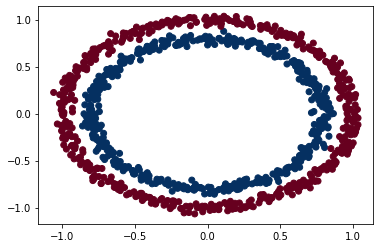

In [6]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdBu)
plt.show()

## convert from numpy to torch.tensor

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Split between test & train

In [8]:
# X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
len(X_train), len(y_train)

(800, 800)

In [10]:
len(X_test), len(y_test)

(200, 200)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Create the model

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Create a nn.sequential

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [14]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1462,  0.3592],
                      [-0.0009, -0.6133],
                      [ 0.4427,  0.3021],
                      [ 0.0377, -0.6793],
                      [ 0.0693,  0.0712]])),
             ('0.bias', tensor([-0.7058, -0.3973,  0.0020, -0.1061,  0.0764])),
             ('1.weight',
              tensor([[-0.0087,  0.0235,  0.0090, -0.2263,  0.2307]])),
             ('1.bias', tensor([0.2618]))])

In [15]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4016],
        [0.4496],
        [0.2425],
        [0.4468],
        [0.1899],
        [0.2196],
        [0.3966],
        [0.3426],
        [0.2449],
        [0.4522]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Set up a loss function & optimizer

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [17]:
def accuracy_fn(y_true, y_predicted):
    correct = torch.eq(y_true, y_predicted).sum().item()
    accuracy = (correct / len(y_predicted)) * 100
    return accuracy

In [18]:
# The logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4016],
        [0.4496],
        [0.2425],
        [0.4468],
        [0.1899]])

In [19]:
# prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5991],
        [0.6105],
        [0.5603],
        [0.6099],
        [0.5473]])

In [20]:
# predicted labels
y_preds = torch.round(y_pred_probs)

# logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

# Build a training & testing loop

In [21]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    # logits -> predicted probabilities -> prediction labels
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    # calculate loss & accuracy, nn.BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_predicted=y_pred)

    # 3. Zero out the gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimization (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_predicted=test_predictions)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\n | Loss: {loss}, Accuracy: {acc:.2f}%"
              f"\n | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0
 | Loss: 0.70453280210495, Accuracy: 50.00%
 | Test loss: 0.71, Test acc: 50.00%
Epoch: 10
 | Loss: 0.6978817582130432, Accuracy: 50.00%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 20
 | Loss: 0.6951332688331604, Accuracy: 55.25%
 | Test loss: 0.70, Test acc: 56.00%
Epoch: 30
 | Loss: 0.6939865946769714, Accuracy: 54.62%
 | Test loss: 0.70, Test acc: 49.50%
Epoch: 40
 | Loss: 0.6934981346130371, Accuracy: 52.50%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 50
 | Loss: 0.6932815313339233, Accuracy: 52.75%
 | Test loss: 0.70, Test acc: 48.00%
Epoch: 60
 | Loss: 0.6931787133216858, Accuracy: 51.62%
 | Test loss: 0.70, Test acc: 50.00%
Epoch: 70
 | Loss: 0.6931245923042297, Accuracy: 51.38%
 | Test loss: 0.70, Test acc: 49.50%
Epoch: 80
 | Loss: 0.6930927038192749, Accuracy: 51.12%
 | Test loss: 0.70, Test acc: 46.50%
Epoch: 90
 | Loss: 0.6930716633796692, Accuracy: 51.25%
 | Test loss: 0.70, Test acc: 46.50%


## Plot decision boundary of model

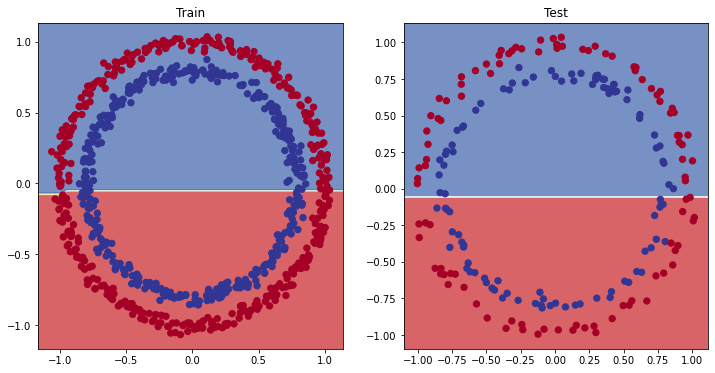

In [22]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Circle Model v2

In [23]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        logit1 = self.layer_1(x)
        logit2 = self.layer_2(logit1)
        logit3 = self.layer_3(logit2)
        # or
        # self.layer_3(self.layer_2(self.layer_1(x)))
        return logit3

model_1 = CircleModelV2().to(device)
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

## Create a loss function & optimizer

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    # logits -> predicted probabilities -> predicted labels
    y_logits = model_1(X_train).squeeze()
    y_predicted = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss & accuracy
    training_loss = loss_fn(y_logits, y_train)
    training_acc = accuracy_fn(y_true=y_train, y_predicted=y_predicted)

    # 3. zero out gradients
    optimizer.zero_grad()

    # 4. backpropagation
    training_loss.backward()

    # 5. optimization(gradient descent)
    optimizer.step()

    # Test
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))
        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_predictions)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n | Training Loss: {training_loss}, Training Accuracy: {training_acc:.2f}%"
              f"\n | Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0
 | Training Loss: 0.6939550638198853, Training Accuracy: 50.88%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 100
 | Training Loss: 0.6930477619171143, Training Accuracy: 50.38%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 200
 | Training Loss: 0.692986011505127, Training Accuracy: 51.12%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 300
 | Training Loss: 0.6929805278778076, Training Accuracy: 51.62%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 400
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.12%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 500
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 600
 | Training Loss: 0.6929798722267151, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 700
 | Training Loss: 0.6929798126220703, Training Accuracy: 51.00%
 | Test Loss: 0.69, Test Accuracy: 47.00%
Epoch: 800
 | Training Loss: 0.6929798722267151, Training Accuracy:

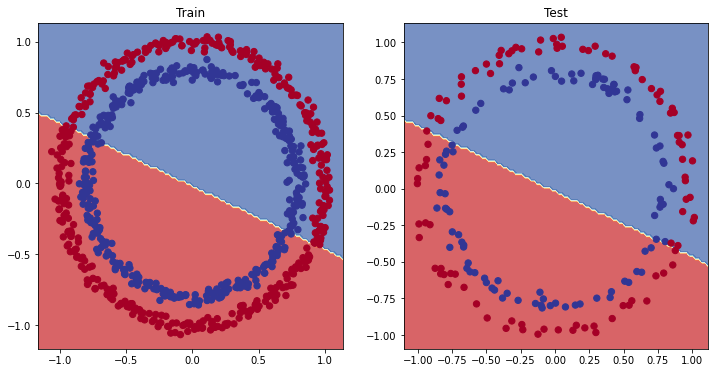

In [26]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Create straight line to see if model is learning

In [29]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias
print(X_regression[:5], '\n', y_regression[:5])

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) 
 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [32]:
train_split = int(.8 * len(X_regression))

# training data
X_train_r = X_regression[:train_split]
y_train_r = y_regression[:train_split]

# to check on unseen data
X_test_r = X_regression[train_split:]
y_test_r = y_regression[train_split:]

print(len(X_train_r), len(y_train_r))
print(len(X_test_r), len(y_test_r))

80 80
20 20
